# Ćwiczenie 3

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry Connect Four (czwórki).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four (ale, tak aby rozwiązanie miało ten sam interfejs co podany poniżej).

Implementację Minimax należy przetestować używając różną głębokość przeszukiwania. Implementacja Solvera musi zapewniać interfejs jak poniżej, ale można dodać dowolne metody prywatne oraz klasy wspomagające (jeżeli będą potrzebne).

Punktacja:
- Działająca metoda Minimax - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania **1.5pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów, bądź kilka przykładów 'z ręki'
- Jakość kodu **2pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [1]:
from typing import Tuple, List
import random
from time import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove

Wielkość planszy

In [2]:
ROW_COUNT = 6
COLUMN_COUNT = 7

Wartości grup

In [3]:
VALUES = np.array([1, 4, 9, 16])

In [4]:
#klasa MiniMaxSolver
class MinMaxSolver:

    def __init__(self, game: ConnectFour):
        self.game = game

    def generate_subarrays(self):
        fields = self.game.state.fields
        matrix = np.array(fields)

        subarrays = []

        # Podtablice kolumn
        subarrays.extend(matrix[i, :] for i in range(matrix.shape[0]))

        # Podtablice wierszy
        subarrays.extend(matrix[:, j] for j in range(matrix.shape[1]))

        # Pobieranie przekątnej z lewej do prawej od długości 1 do 7
        diagonals_left_to_right = [matrix.diagonal(offset=i) for i in range(-6, 6)]
        subarrays.extend(diagonals_left_to_right)

        # Pobieranie przekątnej z prawej do lewej od długści 1 do 7
        diagonals_right_to_left = [np.fliplr(matrix).diagonal(offset=i) for i in range(-6, 6)]
        subarrays.extend(diagonals_right_to_left)

        return subarrays

    def count_groups(self, subarray: list[Player], player: Player) -> list[int]:
        grouped_data = groupby((subarray))

        # Inicjalizuj liczniki
        single_count = 0
        double_count = 0
        triple_count = 0
        quadruple_count = 0

        # Iteruj przez grupy
        for key, group in grouped_data:
            # Oblicz długość grupy
            group_length = len(list(group))
            if key == player:
                # Zlicz wystąpienia pojedyncze, podwójne, potrójne, poczwórne, itd.
                if group_length == 1:
                    single_count += 1
                elif group_length == 2:
                    double_count += 1
                elif group_length == 3:
                    triple_count += 1
                elif group_length == 4:
                    quadruple_count += 1

        # Zwróć wyniki
        return np.array([single_count, double_count, triple_count, quadruple_count])

    def calculate_score_from_array(self, arr):
        return np.sum(VALUES * arr)

    def calculate_score(self, player: Player) -> float:
        # Stworzenie podtablic planszy
        subarrays = self.generate_subarrays()

        # Oblicz wynik dla każdej podtablicy
        scores = []
        for subarray in subarrays:
            # Zlicz grupy
            groups = self.count_groups(subarray, player)
            # Oblicz wynik
            score = self.calculate_score_from_array(groups)
            # Dodaj wynik do listy
            scores.append(score)

        # Zwróć sumę wyników
        return np.sum(scores)

    def evaluate_position(self, player: Player)->float:
        if player == self.game.first_player:
            opponent = self.game.second_player
            factor = 1
        else:
            opponent = self.game.first_player
            factor = -1

        #sprawdzenie czy gra się skończyła
        if self.game.is_finished():
            if self.game.get_winner() == player:
                return np.inf * factor
            else:
                return (-np.inf) * factor
        # jeśli gra się nie skończyła, oblicz ewaluacje pozycji
        else:
            return (factor * self.calculate_score(player)) - (factor * self.calculate_score(opponent))

    def is_valid_move(self, col_index:int)->bool:
        possible_moves = self.game.get_moves()
        if col_index in [move.column for move in possible_moves]:
            return True
        else:
            return False

    def minimax(self, depth, alpha:float, beta:float, is_maximizing_player:bool)-> Tuple[int, float]:
        """Returns column index and score"""
        # jeśli depth to 0 albo gra jest skończona
        if depth == 0 or self.game.is_finished():
            if is_maximizing_player:
                return None, self.evaluate_position(self.game.first_player)
            else:
                return None, self.evaluate_position(self.game.second_player)

        # jeśli mamy podany depth i gra nadal trwa
        if is_maximizing_player:
            best_move = -1
            max_eval = -np.inf
            for column in range(COLUMN_COUNT):
                if self.is_valid_move(column):
                    self.game.make_move(ConnectFourMove(column))
                    current_eval = self.minimax(depth - 1, alpha, beta, False)[1]
                    self.game.reset_move(ConnectFourMove(column))

                    # sprawdzenie czy mamy lepszy ruch
                    if current_eval > max_eval:
                        max_eval = current_eval
                        best_move = column

                    # odcięcie alpha beta
                    alpha = max(alpha, current_eval)
                    if beta <= alpha:
                        break
            return best_move, max_eval

        else:
            best_move = -1
            max_eval = np.inf
            for column in range(COLUMN_COUNT):
                if self.is_valid_move(column):
                    self.game.make_move(ConnectFourMove(column))
                    current_eval = self.minimax(depth - 1, alpha, beta, True)[1]
                    self.game.reset_move(ConnectFourMove(column))

                    # sprawdzenie czy mamy lepszy ruch dla gracza minimalizującego
                    if current_eval < max_eval:
                        max_eval = current_eval
                        best_move = column

                    # odcięcie alpha beta
                    beta = min(beta, current_eval)
                    if beta <= alpha:
                        break
            return best_move, max_eval

**Testowanie poprawności algorytmu minimax**
==


Aby przetestować poprawność zaimplementowanego algorytmu posłużymy się przykładami, w których w łatwy sposób dostrzec, że w kilku ruchach można wygrać, więc sprawdzimy, czy dla odpowiednich wartości głębokości przeszukiwań zwróci nam odpowiednie wyniki.


Przykład 1 :
--
Gracz a  wygra niezależnie od ruchu gracza b, ale gracz   b przewidzi to głębokość 2 w górę, bo dla 1 nie jest w stanie wyłapać kolejnego ruchu po swoim

In [5]:
p1 = Player("a")
p2 = Player("b")
game1 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game1)
game1.make_move(ConnectFourMove(2)) # a
game1.make_move(ConnectFourMove(2)) # b
game1.make_move(ConnectFourMove(3)) # a
game1.make_move(ConnectFourMove(6)) # b
game1.make_move(ConnectFourMove(1)) # a
# Ruch gracza b
print(game1)
print("Minimax dla głębokości 3")
print(solver.minimax(3, -np.inf, np.inf, False))
print("Minimax dla głębokości 2")
print(solver.minimax(2, -np.inf, np.inf, False))
print("Minimax dla głębokości 1")
print(solver.minimax(1, -np.inf, np.inf, False))

Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[ ][a][a][a][ ][ ][b]
Minimax dla głębokości 3
(-1, inf)
Minimax dla głębokości 2
(-1, inf)
Minimax dla głębokości 1
(1, 4)


Jak widać w tym przykładzie, dla głębokości 2, gracz b jest w stanie przewidzieć, że niezależnie jaką pozycję on zajmie i tak przegra, ponieważ gracz a ma aż 2 możliwości wygranej.
Natomiast dla głębokości 1 nie jest w stanie przewidzieć kolejnego ruchu a, dlatego nie zwraca informacji o przegranej z góry, tylko zapewnia ruch, który da mu najwięcej punktów

Przykład 2 : 
--
Gracz a ma wygraną w 1 ruchu i algorytm to zauważy 

In [6]:
p1 = Player("a")
p2 = Player("b")
game2 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game2)
game2.make_move(ConnectFourMove(2)) # a
game2.make_move(ConnectFourMove(2)) # b
game2.make_move(ConnectFourMove(3)) # a
game2.make_move(ConnectFourMove(6)) # b
game2.make_move(ConnectFourMove(1)) # a
game2.make_move(ConnectFourMove(6)) # b
# Ruch gracza a
print(game2)
print("Minimax dla głębokości 1")
print(solver.minimax(1, -np.inf, np.inf, True))
print("Minimax dla głębokości 3")
print(solver.minimax(3, -np.inf, np.inf, True))

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][b]
[ ][a][a][a][ ][ ][b]
Minimax dla głębokości 1
(0, inf)
Minimax dla głębokości 3
(0, inf)


Widzimy, że już od głębokości 1, algorytm minimax przewiduje zwycięstwo a i zwraca nam pierwszy znaleziony przypadek wygranej

Przykład 3 :
--
Gracz a  wygra niezależnie od ruchu b

In [7]:
p1 = Player("a")
p2 = Player("b")
game3 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game3)
game3.make_move(ConnectFourMove(2)) # a
game3.make_move(ConnectFourMove(2)) # b
game3.make_move(ConnectFourMove(3)) # a
game3.make_move(ConnectFourMove(6)) # b
# rusza się a
print(game3)
print("Minimax dla głębokości 2")
print(solver.minimax(2, -np.inf, np.inf, True))
print("minimax dla głębokości 3")
print(solver.minimax(3, -np.inf, np.inf, True))

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[ ][ ][a][a][ ][ ][b]
Minimax dla głębokości 2
(1, 4)
minimax dla głębokości 3
(1, inf)


Jak widzimy, w prosty sposób możemy dostrzec że w 3 kolejnych ruchach wygra a. Nasz algorytm jest w stanie to przewidzieć, dla głębokości 3 i wyższej. Natomiast dla głębokości 1 lub 2 algorytm nie będzie analizował następnego ruchu gracza a więc nie zauważy że ma ruch wygrywający

Przykład 4 :
--
Gracz b jest ruch od wygranej, więc gracz a blokuje


In [8]:
p1 = Player("a")
p2 = Player("b")
game4 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game4)
game4.make_move(ConnectFourMove(2)) # a
game4.make_move(ConnectFourMove(2)) # b
game4.make_move(ConnectFourMove(3)) # a
game4.make_move(ConnectFourMove(2)) # b
game4.make_move(ConnectFourMove(6)) # a
game4.make_move(ConnectFourMove(2)) # b
# rusza się a
print(game4)
print("Minimax dla głębokości 2")
print(solver.minimax(2, -np.inf, np.inf, True))
print("Minimax dla głębokości 1")
print(solver.minimax(1, -np.inf, np.inf, True))

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[ ][ ][a][a][ ][ ][a]
Minimax dla głębokości 2
(2, -8)
Minimax dla głębokości 1
(1, 4)


Jak widzimy, dla głębokości 2, algorytm jest w stanie zobaczyć wygraną gracza b, dlatego blokuje jego wygrywający ruch. Natomiast dla głębokości 1 , algorytm nie przeanalizuje już sytuacji z ruchem b, dlatego wskaże maksymalizujący ilość punktów ruch dla gracza a

Przykład 5 :
--
Gracz a jest ruch od wygranej chyba, że gracz b zablokuje

In [9]:
p1 = Player("a")
p2 = Player("b")
game5= ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game5)
game5.make_move(ConnectFourMove(2)) # a
game5.make_move(ConnectFourMove(3)) # b
game5.make_move(ConnectFourMove(2)) # a
game5.make_move(ConnectFourMove(4)) # b
game5.make_move(ConnectFourMove(2)) # a
# rusza się b
print(game5)
print("Minimax dla głębokości 1")
print(solver.minimax(1, -np.inf, np.inf, False))
print("Minimax dla głębokości 2")
print(solver.minimax(2, -np.inf, np.inf, False))


Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][a][ ][ ][ ][ ]
[ ][ ][a][ ][ ][ ][ ]
[ ][ ][a][b][b][ ][ ]
Minimax dla głębokości 1
(3, 0)
Minimax dla głębokości 2
(2, 14)


Podobnie jak sytuację wyżej, badane było blokowanie ruchów wygrywających. I podobnie jak poprzednio, gracz będzie stanie przewidzieć wygraną przeciwnika dopiero od głębokości przewidywań 2 lub więcej

Przykład 6 :
--
Gracz b wygra niezależnie od ruchu gracza a

In [10]:
p1 = Player("a")
p2 = Player("b")
game6 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game6)
game6.make_move(ConnectFourMove(0)) # a
game6.make_move(ConnectFourMove(3)) # b
game6.make_move(ConnectFourMove(1)) # a
game6.make_move(ConnectFourMove(4)) # b
game6.make_move(ConnectFourMove(0)) # a
game6.make_move(ConnectFourMove(5)) # b
print(game6)
print("Minimax dla głębokości 2")
print(solver.minimax(2, -np.inf, np.inf, True))
print("Minimax dla głębokości 3")
print(solver.minimax(3, -np.inf, np.inf, True))

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
[a][a][ ][b][b][b][ ]
Minimax dla głębokości 2
(-1, -inf)
Minimax dla głębokości 3
(-1, -inf)


Gracz a jest w sytuacji, że niezaależnie od swojego ruchu i tak przegra, ale zauważy to dopiero dla głębokości 2+

Przykład 7 :
--
W tym przykładzie sprawdzimy, czy dla gry, która jest już w trakcie, algorytm jest przewidzieć wygraną dla dużej głębokości przeszukiwań

In [61]:
p1 = Player("a")
p2 = Player("b")
game7 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game7)
game7.make_move(ConnectFourMove(1)) #a
game7.make_move(ConnectFourMove(5)) #b
game7.make_move(ConnectFourMove(2)) #a
game7.make_move(ConnectFourMove(5)) #b
game7.make_move(ConnectFourMove(4)) #a
game7.make_move(ConnectFourMove(3)) #b
game7.make_move(ConnectFourMove(4)) #a
game7.make_move(ConnectFourMove(2)) #b
game7.make_move(ConnectFourMove(2)) #a
game7.make_move(ConnectFourMove(3)) #b
print(game7)
#ruch a
print("Minimax dla głębokości 7 ")
print(solver.minimax(7, -np.inf, np.inf, True))
print("Minimax dla głębokości 9")
print(solver.minimax(9, -np.inf, np.inf, True))

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][a][ ][ ][ ][ ]
[ ][ ][b][b][a][b][ ]
[ ][a][a][b][a][b][ ]
Minimax dla głębokości 7 
(4, 10)
Minimax dla głębokości 9
(4, 14)


Jak widzimy, dla takiej sytuacji, algorytmowi ciężko jest przewidzieć wygraną nawet dla dużej głębokości przeszukiwań, jest duże prawdopodobieństwo że nie istnieje zwycięstwo w takiej partii.
Natomiast widzimy, że dla głębokości 7 i 9 zaleca nam podobny ruch i dla większej głębokości przewiduje, że ta pozycja zagwarantuje lepszą ewaluację pozycji

Przykład 8 :
--

Ewaluacja pozycji, bez wygranych dla małych przeszukiwań

In [5]:
p1 = Player("a")
p2 = Player("b")
game8 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game8)
game8.make_move(ConnectFourMove(1)) #a
game8.make_move(ConnectFourMove(5)) #b
game8.make_move(ConnectFourMove(2)) #a
game8.make_move(ConnectFourMove(3)) #b
game8.make_move(ConnectFourMove(4)) #a
game8.make_move(ConnectFourMove(6)) #b
print(game8)
#ruch a
print("Minimax dla głębokości 3 ")
print(solver.minimax(3, -np.inf, np.inf, True))
print("Minimax dla głębokości 5")
print(solver.minimax(5, -np.inf, np.inf, True))

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][a][a][b][a][b][b]
Minimax dla głębokości 3 
(0, 10)
Minimax dla głębokości 5
(2, 18)


Podobnie jak wyżej dla małych głębokości przeszukiwań algorytm również nie znajduje pozycji wygrancych, gdyż takowych nie ma. Jednakże widzimy, że dla większej głębokości jest w stanie przewidzieć więcej pozycji w przód i zwrócić nam tą najlepszą. I w tym wypadku mimo, że dla głębokości 3 ruch w kolumnie 2 nie jest bardziej opłacalny niż ruch w kolumnie 0, to dla przeszukania 5 pozycji w przód daje większe benefity.

Porównanie czasowe algorytmu minimax z i bez dodatku alfa-beta
==

In [13]:
p1 = Player("a")
p2 = Player("b")
game7 = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
game7.make_move(ConnectFourMove(1)) #a
game7.make_move(ConnectFourMove(5)) #b
game7.make_move(ConnectFourMove(2)) #a
game7.make_move(ConnectFourMove(5)) #b
game7.make_move(ConnectFourMove(4)) #a
game7.make_move(ConnectFourMove(3)) #b
game7.make_move(ConnectFourMove(4)) #a
game7.make_move(ConnectFourMove(2)) #b
game7.make_move(ConnectFourMove(2)) #a
game7.make_move(ConnectFourMove(3)) #b

def get_time(depth: int, game: ConnectFour) -> float:
    solver = MinMaxSolver(game)
    start_time = time()
    solver.minimax(depth, -np.inf, np.inf, True)
    end_time = time()
    return end_time - start_time

Głębokość 6 oraz zaimplementowane alfa-beta. Wykorzystujemy grę z przykładu 7

In [8]:
print(get_time(6, game7))

8.50769329071045


Głębokość 6 oraz brak alfa-beta. Wykorzystujemy grę z przykładu 7 (nie tworzyłem algorytmu bez implementacji alfa-beta, tylko na czas testu zakomeptowałem odpowiednie linie odpowiadające właśnie za część alfa-beta)

In [12]:
print(get_time(6, game7))

80.20912599563599


Wnioski
--
Jak widać odcięcie alfa-beta znacząco wpływa na szybkość działania algorytmu, ponieważ odcina ona wiele poddrzew, które zapewniają gorsze wyniki i nie ma sensu dalsza ich analiza. W naszym przykładzie różnica w wykonaniu była 10 razy dłuższa bez odcięcia alfa-beta

Wykres zależności głębokości przeszukiwań od czasu trwania algorytmu minimax-alfabeta
==

W celu przedstawienia takowego wykresy wybierzemy przykładową grę z wyżej wymienionych, niech będzie to gra z przykładu 7 i skorzystamy z funkcji get_time

In [10]:
depths = [1, 2, 3, 4, 5, 6, 7]
def get_times(depths: List[int], game: ConnectFour) -> List[float]:
    return [get_time(depth, game) for depth in depths]


In [16]:
timer_without_alfa_beta = get_times(depths, game7)

In [14]:
timer = get_times(depths, game7)

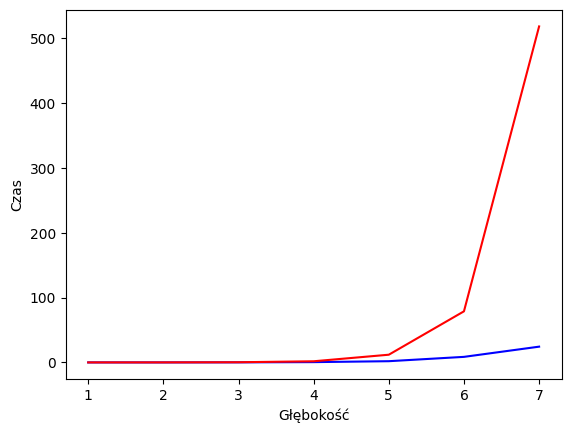

In [17]:
plt.plot(depths, timer, color="blue")
plt.plot(depths, timer_without_alfa_beta, color="red")
plt.xlabel("Głębokość")
plt.ylabel("Czas")
plt.show()

Wnioski
--
Czas przeszukiwań rośnie w znaczący sposób (wykładniczy wręcz), ponieważ z każdym kolejnym przeszukaniem dochodzi nam kolejnych 7 pozycji dla istniejących już, ale algorytm alfa-betaczęść z nich odcina.
Ogolną ilość pozycji do sprawdznia z głębokością można określić wzorem E(suma od i = 1 do głębokości) 7^i

Symulacja rozgrywek dla różnych głębokości
==

W celu takiej symulacji napisałem prostą funkcję, która automatycznie rozgrywa grę, i przyjmuje za parametr głębokość przeszukiwań i ilość rund do zagrania

In [88]:
def ai_vs_ai(number_of_iterations: int, depth: int):
    # Tworzenie graczy
    p1 = Player("a")
    p2 = Player("b")
    # Tworzenie gry
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    solver = MinMaxSolver(game)
    for rounds in range(number_of_iterations):
        print("Round number : ", rounds)
        print("Ruch a")
        move = solver.minimax(depth, -np.inf, np.inf, True)[0]
        game.make_move(ConnectFourMove(move))
        print(game)
        if game.is_finished():
            print("Wygrał gracz a")
            break
        print("Ruch b")
        move = solver.minimax(depth, -np.inf, np.inf, False)[0]
        game.make_move(ConnectFourMove(move))
        print(game)
        if game.is_finished():
            print("Wygrał gracz b")
            break
    print(game)

Przykład 1 :
--
Symulacja 6 rund dla głębokości 3

In [91]:
ai_vs_ai(6, 3)

Round number :  0
Ruch a
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
Ruch b
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
Round number :  1
Ruch a
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][a][ ][ ][ ][ ][ ]
Ruch b
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][a][ ][ ][ ][ ][ ]
Round number :  2
Ruch a
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
Ruch b
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][a][a][b][ ][ ][ ]
Roun

Przykład 2 :
--
Symulacja 6 rund dla głębokości 5

In [92]:
ai_vs_ai(6, 5)

Round number :  0
Ruch a
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
Ruch b
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
Round number :  1
Ruch a
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][a][ ][ ][ ][ ][ ]
Ruch b
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][b][ ][ ][ ][ ][ ]
[a][a][ ][ ][ ][ ][ ]
Round number :  2
Ruch a
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][b][ ][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
Ruch b
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][b][ ][ ][ ][ ][ ]
[a][a][a][b][ ][ ][ ]
Roun

Patrząc na te 2 przykłady widzimy, że w zależności od głębokości przeszukiwań, nasza gra toczy się w inny sposób. Gracze przewidują dla siebie jak najlepsze ruchy, jednocześnie blokując ruchy dobre dla rywala / lub jego wygrywające.
Jeżeli obra ruchy gra komputer to spodziewamy się raczej remisu

Symulajca gry : gracz kontra komputer
==

W tym celu napisałem prostą funkcję umożliwiającą grę na komputer

In [19]:
def ai_vs_player(depth):
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    solver = MinMaxSolver(game)
    while game.is_finished() is False:
        print("ruch komputera")
        print(solver.minimax(depth, -np.inf, np.inf, True))
        move = solver.minimax(depth, -np.inf, np.inf, True)[0]
        game.make_move(ConnectFourMove(move))
        print(game)
        print(" ")
        if game.is_finished():
            break
        print("ruch gracza")
        player_move = int(input())
        game.make_move(ConnectFourMove(player_move))
        print(game)
        print(" ")
        if game.is_finished():
            break
    print("Koniec gry")

Symulacja rozgrywki : 

In [20]:
ai_vs_player(3)

ruch komputera
(0, 6)
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
 
ruch gracza
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][b][ ][ ][ ][ ][ ]
 
ruch komputera
(0, 8)
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
[a][b][ ][ ][ ][ ][ ]
 
ruch gracza
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
[a][b][b][ ][ ][ ][ ]
 
ruch komputera
(0, 14)
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
[a][b][b][ ][ ][ ][ ]
 
ruch gracza
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[a][ ][ ][ ][ ][ ][ ]
[a][b][ ][ ][ ][ ][ ]
[a][b][b]

Wnioski
==

Jak widać algorytm minimax, bardzo dobrze sprawdza się w gracz dwuosobowych, ponieważ jest w stanie przewidzieć wiele ruchów do przodu i tym samym wybrać dla siebie najbardziej optymalny. Wiele jednak zależy od heurystki oceny pozycji, jaka zostanie zaiplementowana w algorytmie. W moim przypadku wybrana została prosta, jednakże spełnia ona swoją rolę i przeiwduje zwycięstwa bądź porażki dla różnych głębokości.
